##### Sensitivity Analysis Simulation of the effect of Energy Producer Maximum outPut on the Voltage Rise Detected 

Simulation based on  : 
* Prediction block RNN trained in [RNN_Train_StLaurentDeJourdes](RNN_Train_StLaurentDeJourdes.ipynb) 
    * To predict $X(k)$ and $Y(k)$  as respectively  $\tilde{X(k)}$ an  $\tilde{Y(k)}$ (Predictions on testing set are done in [RNN_Sim_StLaurentDeJourdes](RNN_Sim_StLaurentDeJourdµes.ipynb))
* RObust RNN To predict $X(k)$ and $Y(k)$  as respectively  $\tilde{X(k)}$ an  $\tilde{Y(k)}$ based on robust Model1 and Model 3[2021_2022_RNN_Robust_All_Models](2021_2022_RNN_Robust_All_Models.ipynb))
* Prediction Block Future Known [2021_2022_KnownFuture](2021_2022_KnownFuture.ipynb)
* Persistence Model [2021_2022_Persistence](2021_2022_Persistence.ipynb)


Maximum voltage rise $vm_{pu}^{max} = 1.0250 $

---

In [32]:
def initVarsFor_ParEngines(pred_df, upscaling_coef):

    
    df_prodHT = pred_df.iloc[:,2:]
    df_prodHT.columns = ['P0013','P0018','P0100'] # Rename column 
    
    # Upscale P0100 based on its maximum value range
    df_prodHT.P0100 = upscaling_coef*df_prodHT.P0100/P0100_max

    df_prod_bt_total = pred_df.iloc[:,[1]]
    df_prod_bt_total.columns = ['Prod_BT']

    df_cons_total = pred_df.iloc[:,[0]]
    df_cons_total.columns = ['Cons']

    # Define a dict 
    dict_df_sgenLoad = dict({'df_prodHT':df_prodHT, 
                             'df_prod_bt_total':df_prod_bt_total, 
                             'df_cons_total':df_cons_total } )
    
    return df_prodHT, dict_df_sgenLoad



def Init_ParEngines_Parameters (df_prodHT, opf_status, dict_df_sgenLoad, parameters_dict, nb_exec ):

    if nb_exec == 0 : 
        # Clear the localspace of all engines
        dview.clear() 

        # # Import following modules on the local space of clients or engines
        with rc[:].sync_imports():
            import numpy, pandapower,pandas, Par_myFunctions

    # Share the total number of period in df_prodHT.index among all the created engines
    dview.scatter('period_part', df_prodHT.index)
    
    # Add all variables in the parameters_dict  to  the local space of each client
    dview.push(parameters_dict) 
                       
    # Send following Variables to local space of parallel engines
    dview['opf_status'] = opf_status  
    dview['dict_df_sgenLoad'] = dict_df_sgenLoad   
    
    
    
def block_pf_Opf(df_prodHT, opf_status, pred_model=None): 
    
    if pred_model == 'Pers': 
    # Run problem in parallel
        %px par_run_Results = [Par_myFunctions.run_powerflow_at(net_civaux, cur_period+1, net_civaux_hv_activated_bus, sum_max_main_network,  dict_df_sgenLoad, vm_mu_max, opf_status, pred_model) for cur_period in period_part]
    else:
        %px par_run_Results = [Par_myFunctions.run_powerflow_at(net_civaux, cur_period, net_civaux_hv_activated_bus, sum_max_main_network,  dict_df_sgenLoad, vm_mu_max, opf_status) for cur_period in period_part]
        
        
    results = dview.gather('par_run_Results')
    time.sleep(2) # Wait before continuing the execution

    if opf_status =='Both': 
        # Extract results
        extracted_results = mf.extract_par_results(results, df_prodHT)
        return extracted_results
    
    elif opf_status== False: 
        # Put data in dataframe
        max_vm_pu_rnn_df = pd.DataFrame(data=np.array(results), 
                                        index=df_prodHT.index, columns=['RNN'],)
        return max_vm_pu_rnn_df
    
    else: raise valueError ('<opf_status> must be either of [False, ''Both'']')


def block_prod(extracted_results, df_final, upscaling_coef):
    extracted_results.loc[per_index2[day_tot_per:], ['P0100']] = (np.minimum(df_final.loc[per_index2[day_tot_per:], 'P0100']*upscaling_coef/P0100_max,
                                                                             extracted_results.loc[per_index2[day_tot_per:], 'P0100']))
    
    return extracted_results

#### Import Modules 


In [2]:
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
from pandapower.control.controller.const_control import ConstControl
from pandapower.timeseries.data_sources.frame_data import DFData
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.timeseries.output_writer import OutputWriter
from pandapower.plotting import simple_plot,simple_plotly,pf_res_plotly
import ipyparallel as ipp
import math as mt
import pandapower.plotting as pt
from pandapower.plotting.plotly import simple_plotly
from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf
import joblib

In [3]:
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import myFunctions as mf
from myFunctions import network_folder, excel_folder, py_folder, Δt, attr_list

#### Import Networks


In [4]:
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p')
net_stlaurent=pp.from_pickle(f'{network_folder}ST LAURENT.p')

# Compute the total of BT prod and Load on St Laurent
sum_max_p_mw_StLaurent_prodBT =net_stlaurent.sgen[net_stlaurent.sgen.name.isna()].max_p_mw.sum()
sum_max_p_mw_StLaurent_load = net_stlaurent.load.max_p_mw.sum()

# To use later in functions 
sum_max_main_network = (sum_max_p_mw_StLaurent_prodBT, sum_max_p_mw_StLaurent_load)


#### Import and dataClead files for component of the network

In [5]:
#Load files
file_p_inj_0013 = 'Prod_HTA/PROD_Bis/P0013/PROD-BATISOLAIRE 6-CIVAUX - Actif injecte (P-).csv'
file_p_inj_0018 = 'Prod_HTA/PROD_Bis/P0018/PROD-SUN POITOU 2516 (Z.I de la Pitage)-LHOMMAIZE - Actif injecte (P-).csv'


# The  commissioning of the Prod P0100 is recent (2022). I therefore use the data of the closer energy 
# producer that is P0058  and consider it as that of Prod P0100 
file_p_inj_0100 = 'Prod_HTA/PROD_Bis/PROD-SERGIES 2204 (LA ROCHE A CORNUCHON)-PINDRAY - Actif P-.csv'

file_prod_bt_total = 'PROD_BTSUP36_SAINT LAURENT.csv'
file_cons_total = 'CONSO_POSTE_SAINT LAURENT.csv'


# Get files data 
p_mw_0013 = mf.readAndReshape_input(file_p_inj_0013 ,excel_folder, )
p_mw_0018 = mf.readAndReshape_input(file_p_inj_0018 ,excel_folder,)
p_mw_0100 = mf.readAndReshape_input(file_p_inj_0100 ,excel_folder,)


p_mw_prod_bt_total = mf.readAndReshape_input(file_prod_bt_total, excel_folder)
p_mw_cons_total = mf.readAndReshape_input(file_cons_total, excel_folder)

# Create dict for all HT producers
dict_prod_hv = {'P0013': p_mw_0013[:len(p_mw_0100)], 
                'P0018': p_mw_0018[:len(p_mw_0100)],
                'P0100': p_mw_0100[:len(p_mw_0100)]
               }
# Create index to use for dataframe
per_index = pd.period_range('01 01 2020', periods=len(p_mw_0100), freq='10T')

# Use the create dict to create a dataFrame for Prod P0100
df_prodP0100 = pd.DataFrame(p_mw_0100, index=per_index)

# Use the create dict to create a dataFrame for all HT producers
df_prodHT = pd.DataFrame(dict_prod_hv, index=per_index)

# Dataframe prod BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_prod_bt_total), freq='10T')
df_prod_bt_total = pd.DataFrame(p_mw_prod_bt_total, index=per_index, columns=['Prod_BT'])


# Dataframe Conso BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_cons_total), freq='10T')
df_cons_total = pd.DataFrame(p_mw_cons_total, index=per_index, columns=['Cons'])
# Data cleaning on Consumption
previous_days = df_cons_total[(per_index>='2022 02 12') & (per_index<='2022 02 21 23:50')]
following_days = df_cons_total[(per_index>='2022 03 03') & (per_index<='2022 03 12 23:50')]
# # Put the interpolated data into the dataframe
df_cons_total[(per_index>='2022 02 21') & (per_index<='2022 03 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2


# Get total Power of BT producers
# Bt producers are indexed by the name None
max_p_mw_total_prodBT = net_civaux.sgen.max_p_mw[net_civaux.sgen.name.isna()].sum()

# # Get total power of load in the network
max_p_mw_total_load = net_civaux.load.max_p_mw.sum()

# Select relevant data up to 2022 06 01
df_prodHT = df_prodHT[df_prodHT.index<='2022 06 01 23:50']
df_prod_bt_total = df_prod_bt_total[df_prod_bt_total.index<='2022 06 01 23:50']
df_cons_total = df_cons_total[df_cons_total.index<='2022 06 01 23:50']


# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. 
h_start_end = ('07:00','18:50') # for the persistance model, the previous period i.e. 06:50 
                                # is needed to compute the first instant i.e. 07:00
per_index = df_prodHT.index
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object).between_time(*h_start_end) ).index.to_period('10T')
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])


# Put all the data in a unique dataframe
df_data = pd.concat([df_cons_total, df_prod_bt_total, df_prodHT], axis=1).loc[per_daylight]

# # Extract only the relavant testing set since the training set covers the first part of the data
df_final = df_data[df_data.index>='2021 06 01']
per_index = df_final.index
per_index2 = ( pd.Series(index=per_index.to_timestamp(), dtype=object
                           ).between_time('07:00','18:50') ).index.to_period('10T')


##### Load prediction file

In [6]:
rnnPred_df = joblib.load('pickle_files/simulationResults/RNN_pred.pkl')

#### Data extraction on the network

In [7]:
net_civaux_hv_bus = list(net_civaux.bus.groupby('vn_kv'))[1][1] # Extract HV bus in the network

pp.runpp(net_civaux) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index = list(net_civaux.res_bus.vm_pu[net_civaux.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux_hv_activated_bus = [i for i in activated_bus_index 
                               if i in net_civaux_hv_bus.index]

#### Start Parallel engines

In [8]:
n_engines = 6                      # Total number of engines
# (Use the real maximum cpu and not the logical)            
cluster = ipp.Cluster(n=n_engines) # Create cluster
cluster.start_cluster_sync()       # Start cluster 
rc = cluster.connect_client_sync() # connect client
rc.wait_for_engines(n_engines)     # Wait for engines to be available for all clients
dview = rc[:]                      # Create a direct view of all engine or clients that would
                                   # be used to command each client

Starting 6 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

## OPF  RNN

#### Load network

In [9]:
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p') # Reload network with new name 

# Add a controllable line to the static generators
net_civaux.sgen['controllable'] = False 

# Set the producer P0100 as a controllable load
net_civaux.sgen['controllable'][net_civaux.sgen.name=='P0100'] = True

# Add Missing columns to be able to un an opf 
net_civaux.sgen[['min_p_mw', 'min_q_mvar', 'max_q_mvar']]=0.

# Rename data in bus network because the names do not correspond to the parameters in pandapower 
net_civaux.bus.rename({'max_vw_pu':'max_vm_pu',}, axis=1, inplace=True)

net_civaux.bus.drop(['max_vm', 'min_vm'], axis=1, inplace=True)    # Delete useless parameters
net_civaux_hv_bus = list(net_civaux.bus.groupby('vn_kv'))[1][1]   # Extract HV bus in the network

pp.runpp(net_civaux) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index2 = list(net_civaux.res_bus.vm_pu[net_civaux.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux_hv_activated_bus = [i for i in activated_bus_index2 
                               if i in net_civaux_hv_bus.index]

#### Add maximum voltage constraints on the Buses in the network 

In [10]:
vm_mu_max, vm_mu_min = 1.0250, 0.95  # Choosen 
# vm_mu_max, vm_mu_min = 1.0225, 0.95  # Choosen 

# net_civaux.bus.max_vm_pu[net_civaux.bus.max_vm_pu.notna()] = vm_mu_max
net_civaux.bus.max_vm_pu[net_civaux_hv_activated_bus] = vm_mu_max
net_civaux.bus.min_vm_pu[net_civaux_hv_activated_bus] = vm_mu_min


In [11]:
# Add negative cost to usability of sgen P0100 so its usage can be maximised while respecting the constraints on the network
cost_sgen_p0100 = pp.create_poly_cost(net_civaux,23,'sgen', cp1_eur_per_mw=-1)
# net_civaux.poly_cost.cp1_eur_per_mw.at[cost_sgen_p0100]=-0.5
net_civaux.poly_cost

,element,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,23,sgen,0.0,-1.0,0.0,0.0,0.0,0.0


#### Redefine Data to use in local space of engines

In [18]:
# Create a dictionnary containing all the varible that will be used by each client or engine
pred_model = 'Pers'

parameters_dict = dict({'net_civaux':net_civaux, 
                        'net_civaux_hv_activated_bus':net_civaux_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'vm_mu_max':vm_mu_max,
                        'pred_model':pred_model
                         })

---

#### Robust Persistence

In [34]:
sim_res_Dict = {}  # Dictionnary to save variables

P0100_max = 4      #Define the maximum power output subscribed by P0100 

# Define Range for the maximum power output subscribed by P0100 
P0100_max_range = np.arange(0, P0100_max+0.1 ,0.2)



for mr_index in range(len(P0100_max_range)):
    upscaling_coef = P0100_max_range[mr_index]  # Define upsacaling coeff

    # Initialize variables for parallel engines
    df_prodHT, dict_df_sgenLoad = initVarsFor_ParEngines(df_final, upscaling_coef)
    print(f'***************************       Simulation {mr_index+1}/{len(P0100_max_range)}      ****************')
    print("                           ------- Bloc PF/OPF ---------         ")
    ##          ---------------------------  BLOCK PF/OPF  ------------------------         ##
    # Initialize the parallel engine parameters i.e. send varible into each local space
    opf_status = 'Both'
    Init_ParEngines_Parameters(df_prodHT, opf_status, dict_df_sgenLoad, parameters_dict, 0 )

    # cALL Block pf/op
    extracted_results = block_pf_Opf(df_prodHT, opf_status, pred_model)    

    
    # ---------------------- Implement Robust Persistence ------------------------------------
    # create new period index mask spaning from 08Am to 6PM
    per_index2 = per_index.to_timestamp().to_series().between_time('07:10','18:50').index.to_period('10T')

    # Create a new df for P0100 
    df_p0100_pers_improved = pd.DataFrame(index=per_index2, columns=['P0100_Pers_Imp'])

    # Get into the dataframe data of P0100 When there is no control
    df_p0100_pers_improved.loc[per_index2,['P0100_Pers_Imp'] ] = upscaling_coef*df_final.loc[per_index2].P0100/P0100_max
    
    # Get a mask for the periods where a voltage rise above the threshold is predicted 
    mask_vrise_per = extracted_results.loc[per_index2, 'max_vm_pu_pf']>vm_mu_max
    
    # Replace the values of periods given by the mask by the value of P0100 period given 
    df_p0100_pers_improved[mask_vrise_per] = extracted_results.loc[mask_per_index].loc[mask_vrise_per,['P0100']]

    # Replace the values of P0100 in the extracted results dataframe
    extracted_results.loc[per_index2, ['P0100']] = df_p0100_pers_improved.loc[per_index2, 'P0100_Pers_Imp']  
    
    
    
    ##             ---------------------------  BLOCK PROD  ------------------------         ##
    extracted_results = block_prod(extracted_results, df_final, upscaling_coef)


    # Update Values for the dict to use for final power flow bloc
    day_tot_per = day_tot_per-1
    prod_hv_df = pd.concat([df_final.loc[per_index2[day_tot_per:], ['P0013', 'P0018']], 
                            extracted_results.loc[per_index2[day_tot_per:], ['P0100']]], axis=1)

    dict_df_sgenLoad = dict({'df_prodHT': prod_hv_df, 
                             'df_prod_bt_total':df_final.loc[per_index2[day_tot_per:], ['Prod_BT']], 
                             'df_cons_total':df_final.loc[per_index2[day_tot_per:], ['Cons']] } )


    ##             ---------------------------  BLOCK PF  ------------------------         ##
    print("                            ------- Bloc PF/OPF ---------         ")

    opf_status = False
    # Initialize the parallel engine parameters i.e. send varible into each local space for PF
    Init_ParEngines_Parameters(prod_hv_df, opf_status, dict_df_sgenLoad, parameters_dict, 1)

    # cALL Block pf
    max_vm_pu_pers_df = block_pf_Opf(prod_hv_df, opf_status)    



    #####   Saving Results 
    P0100_df = df_final.loc[prod_hv_df.index, ['P0100']]
    P0100_pers_df = pd.DataFrame(data=extracted_results.loc[prod_hv_df.index].P0100.values, 
                                 index=extracted_results.loc[prod_hv_df.index].index, 
                                 columns=['Pers_Rob Sim'+str(mr_index+1)] )
    # Concat
    P0100_concat_df = pd.concat([P0100_max_range[mr_index]*P0100_df/P0100_max,P0100_pers_df], axis=1)
    # Rename
    P0100_concat_df.rename(columns=({'P0100':'No_Control'}), inplace=True);


    int_sim_res = {'maxV_rise_df':max_vm_pu_pers_df,              # Intermediate results
                   'Power Sgen': P0100_concat_df}         
    sim_res_Dict.update([('Sim'+str(mr_index+1),int_sim_res)])   # Final results


                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

#### FUTURE KNOWN

In [15]:
sim_res_Dict = {}  # Dictionnary to save variables

P0100_max = 4      #Define the maximum power output subscribed by P0100 

# Define Range for the maximum power output subscribed by P0100 
P0100_max_range = np.arange(0, P0100_max+0.1 ,0.2)



for mr_index in range(len(P0100_max_range)):
    upscaling_coef = P0100_max_range[mr_index]  # Define upsacaling coeff

    # Initialize variables for parallel engines
    df_prodHT, dict_df_sgenLoad = initVarsFor_ParEngines(df_final, upscaling_coef)
    print(f'***************************       Simulation {mr_index+1}/{len(P0100_max_range)}      ****************')
    print("                           ------- Bloc PF/OPF ---------         ")
    ##          ---------------------------  BLOCK PF/OPF  ------------------------         ##
    # Initialize the parallel engine parameters i.e. send varible into each local space
    opf_status = 'Both'
    Init_ParEngines_Parameters(df_prodHT, opf_status, dict_df_sgenLoad, parameters_dict, 0 )

    # cALL Block pf/op
    extracted_results = block_pf_Opf(df_prodHT, opf_status)    

    # Get maximum voltage over the network 
    max_vm_pu_df_known = extracted_results[['max_vm_pu']]
    max_vm_pu_df_known.rename(columns={'max_vm_pu':'Fut_Known'}, inplace=True)
    max_vm_pu_pf_df = extracted_results[['max_vm_pu_pf']] 
    
    
    #####   Saving Results 
    mask = per_index2[day_tot_per:]
    P0100_known_df = pd.DataFrame(data=extracted_results.loc[mask].P0100.values, 
                                 index=extracted_results.loc[mask].index, 
                                 columns=['Fut_Known Sim'+str(mr_index+1)] )
    # Concat
    P0100_df = df_final.loc[mask, ['P0100']]
    P0100_concat_df = pd.concat([P0100_max_range[mr_index]*P0100_df/P0100_max, 
                                 P0100_known_df], axis=1)
    # Rename
    P0100_concat_df.rename(columns=({'P0100':'No_Control'}), inplace=True);


    int_sim_res = {'maxV_rise_df':max_vm_pu_df_known,            # Intermediate results
                   'Power Sgen': P0100_concat_df,
                   'maxV_rise_pf_df':max_vm_pu_pf_df}         
    sim_res_Dict.update([('Sim'+str(mr_index+1),int_sim_res)])   # Final results


***************************       Simulation 1/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 2/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 3/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 4/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 5/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 6/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 7/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 8/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 9/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 10/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 11/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 12/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 13/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 14/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 15/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 16/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 17/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 18/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 19/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 20/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 21/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

In [16]:
joblib.dump(sim_res_Dict,'pickle_files/simulationResults/SensAnalysisP0100_FutureKnown.pkl')

['pickle_files/simulationResults/SensAnalysisP0100_FutureKnown.pkl']

---

#### USING THE RNN 

In [130]:
sim_res_Dict_rnn = {}  # Dictionnary to save variables

P0100_max = 4      #Define the maximum power output subscribed by P0100 

# Define Range for the maximum power output subscribed by P0100 
P0100_max_range = np.arange(0, P0100_max+0.1 ,0.2)



for mr_index in range(len(P0100_max_range)): 
    print(mr_index)
    upscaling_coef = P0100_max_range[mr_index]  # Define upsacaling coeff

    # Initialize variables for parallel engines
    df_prodHT, dict_df_sgenLoad = initVarsFor_ParEngines(rnnPred_df, upscaling_coef)
    print(f'***************************       Simulation {mr_index+1}/{len(P0100_max_range)}      ****************')
    print("                           ------- Bloc PF/OPF ---------         ")
    ##          ---------------------------  BLOCK PF/OPF  ------------------------         ##
    # Initialize the parallel engine parameters i.e. send varible into each local space
    opf_status = 'Both'
    Init_ParEngines_Parameters(df_prodHT, opf_status, dict_df_sgenLoad, parameters_dict, 0 )

    # cALL Block pf/op
    extracted_results = block_pf_Opf(df_prodHT, opf_status)    


    ##             ---------------------------  BLOCK PROD  ------------------------         ##
    extracted_results = block_prod(extracted_results, df_final, upscaling_coef)


    # Update Values for the dict to use for final power flow bloc
    prod_hv_df = pd.concat([df_final.loc[per_index2[day_tot_per:], ['P0013', 'P0018']], 
                            extracted_results.loc[per_index2[day_tot_per:], ['P0100']]], axis=1)

    dict_df_sgenLoad = dict({'df_prodHT': prod_hv_df, 
                             'df_prod_bt_total':df_final.loc[per_index2[day_tot_per:], ['Prod_BT']], 
                             'df_cons_total':df_final.loc[per_index2[day_tot_per:], ['Cons']] } )


    ##             ---------------------------  BLOCK PF  ------------------------         ##
    print("                            ------- Bloc PF/OPF ---------         ")

    opf_status = False
    # Initialize the parallel engine parameters i.e. send varible into each local space for PF
    Init_ParEngines_Parameters(prod_hv_df, opf_status, dict_df_sgenLoad, parameters_dict, 1)

    # cALL Block pf
    max_vm_pu_rnn_df = block_pf_Opf(prod_hv_df, opf_status)    



    #####   Saving Results 
    P0100_df = df_final.loc[prod_hv_df.index, ['P0100']]
    P0100_rnn_df = pd.DataFrame(data=extracted_results.loc[prod_hv_df.index].P0100.values, 
                                 index=extracted_results.loc[prod_hv_df.index].index, 
                                 columns=['RNN Sim'+str(mr_index+1)] )
    # Concat
    P0100_concat_df = pd.concat([P0100_max_range[mr_index]*P0100_df/P0100_max,P0100_rnn_df], axis=1)
    # Rename
    P0100_concat_df.rename(columns=({'P0100':'No_Control'}), inplace=True);


    int_sim_res = {'maxV_rise_df':max_vm_pu_rnn_df,              # Intermediate results
                   'Power Sgen': P0100_concat_df}         
    sim_res_Dict.update([('Sim'+str(mr_index+1),int_sim_res)])   # Final results


0
***************************       Simulation 1/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

1
***************************       Simulation 2/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

2
***************************       Simulation 3/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

3
***************************       Simulation 4/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

4
***************************       Simulation 5/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

5
***************************       Simulation 6/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

6
***************************       Simulation 7/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

7
***************************       Simulation 8/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

8
***************************       Simulation 9/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

9
***************************       Simulation 10/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

10
***************************       Simulation 11/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

11
***************************       Simulation 12/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

12
***************************       Simulation 13/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

13
***************************       Simulation 14/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

14
***************************       Simulation 15/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

15
***************************       Simulation 16/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

16
***************************       Simulation 17/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

17
***************************       Simulation 18/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

18
***************************       Simulation 19/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

19
***************************       Simulation 20/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

20
***************************       Simulation 21/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

In [140]:
joblib.dump(sim_res_Dict,'pickle_files/simulationResults/SensAnalysisP0100_RNN.pkl')


['pickle_files/simulationResults/SensAnalysisP0100_RNN.pkl']

#### USING ROBUST RNN 

In [71]:
pred_num_vRise = joblib.load('pickle_files/simulationResults/Numerical_Voltage_Rise_Predicted.pkl')
pred_bin_vRise = joblib.load('pickle_files/simulationResults/Binary_Voltage_Rise_Predicted.pkl')

mask_per2work = pred_bin_vRise[pred_bin_vRise.index>='2021 06 02'].index # We select from the second day of testing set 
# since Model1  needs a whole day to predict the first period

mask_per2work = mask_per2work.to_timestamp().to_series().between_time('08:10','18:30').index.to_period('10T')


In [72]:
sim_res_Dict_rnn_rob = {}  # Dictionnary to save variables

P0100_max = 4      #Define the maximum power output subscribed by P0100 

# Define Range for the maximum power output subscribed by P0100 
P0100_max_range = np.arange(0, P0100_max+0.1 ,0.2)



for mr_index in range(len(P0100_max_range)): 
    upscaling_coef = P0100_max_range[mr_index]  # Define upsacaling coeff

    # Initialize variables for parallel engines
    df_prodHT, dict_df_sgenLoad = initVarsFor_ParEngines(rnnPred_df.loc[mask_per2work], upscaling_coef)
    print(f'***************************       Simulation {mr_index+1}/{len(P0100_max_range)}      ****************')
    print("                           ------- Bloc PF/OPF ---------         ")
    ##          ---------------------------  BLOCK PF/OPF  ------------------------         ##
    # Initialize the parallel engine parameters i.e. send varible into each local space
    opf_status = 'Both'
    Init_ParEngines_Parameters(df_prodHT.loc[mask_per2work], opf_status, dict_df_sgenLoad, parameters_dict, 0 )

    # cALL Block pf/op
    extracted_results = block_pf_Opf(df_prodHT, opf_status)    


    ##          ---------------------------  BLOCK ROBUST PRED  ------------------------         ##
    model1_Vrise, model2_Vrise, model3_Vrise = (extracted_results[['max_vm_pu_pf']].loc[mask_per2work], 
                                                pred_num_vRise.loc[mask_per2work], 
                                                pred_bin_vRise.loc[mask_per2work] )
    
    # create a dictionnary to save modelVrise
    v_rise_dict = {name: model for name, model in zip(['Model'+str(i) for i in range(1,4)],
                                                      [model1_Vrise, model2_Vrise, model3_Vrise] ) }
    model_name = 'Model3'

    # Extract P0100 based on robust prediction of threshold
    P0100_opt, all_me = mf.robustPred(v_rise_dict, 
                                      df_final[['P0100']]*upscaling_coef/P0100_max, 
                                      extracted_results[['P0100']],vm_mu_max, model_name)



    ##             ---------------------------  BLOCK PROD  ------------------------         ##
    P0100_opt.loc[mask_per2work,['P0100']] = np.minimum(df_final.loc[mask_per2work, 'P0100']*upscaling_coef/P0100_max,
                                                        P0100_opt.P0100)
    extracted_results = P0100_opt


    # Update Values for the dict to use for final power flow bloc
    prod_hv_df = pd.concat([df_final.loc[mask_per2work, ['P0013', 'P0018']], 
                            extracted_results.loc[mask_per2work, ['P0100']]], axis=1)

    dict_df_sgenLoad = dict({'df_prodHT': prod_hv_df, 
                             'df_prod_bt_total':df_final.loc[mask_per2work, ['Prod_BT']], 
                             'df_cons_total':df_final.loc[mask_per2work, ['Cons']] } )

    
    ##             ---------------------------  BLOCK PF  ------------------------         ##
    print("                            ------- Bloc PF/OPF ---------         ")

    opf_status = False
    # Initialize the parallel engine parameters i.e. send varible into each local space for PF
    Init_ParEngines_Parameters(prod_hv_df, opf_status, dict_df_sgenLoad, parameters_dict, 1)

    # cALL Block pf
    max_vm_pu_rnn_df = block_pf_Opf(prod_hv_df, opf_status)    



    #####   Saving Results 
    P0100_df = df_final.loc[prod_hv_df.index, ['P0100']]
    P0100_rnn_df = pd.DataFrame(data=extracted_results.loc[prod_hv_df.index].P0100.values, 
                                 index=extracted_results.loc[prod_hv_df.index].index, 
                                 columns=['RNN Sim'+str(mr_index+1)] )
    # Concat
    P0100_concat_df = pd.concat([P0100_max_range[mr_index]*P0100_df/P0100_max,P0100_rnn_df], axis=1)
    # Rename
    P0100_concat_df.rename(columns=({'P0100':'No_Control'}), inplace=True);


    int_sim_res = {'maxV_rise_df':max_vm_pu_rnn_df,              # Intermediate results
                   'Power Sgen': P0100_concat_df}         
    sim_res_Dict_rnn_rob.update([('Sim'+str(mr_index+1),int_sim_res)])   # Final results


***************************       Simulation 1/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 2/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 3/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 4/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 5/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 6/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 7/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 8/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 9/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 10/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 11/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 12/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 13/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 14/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 15/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 16/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 17/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 18/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 19/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 20/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

***************************       Simulation 21/21      ****************
                           ------- Bloc PF/OPF ---------         
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

                            ------- Bloc PF/OPF ---------         


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

In [73]:
joblib.dump(sim_res_Dict_rnn_rob,'pickle_files/simulationResults/SensAnalysisP0100_RNN_Robust_Model3.pkl')

['pickle_files/simulationResults/SensAnalysisP0100_RNN_Robust_Model3.pkl']

In [ ]:
# var = joblib.load('pickle_files/simulationResults/RNN_pred_res_AtLeast3Model.pkl')


<AxesSubplot:>

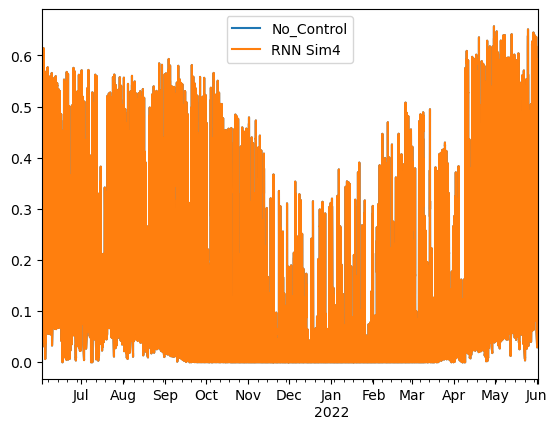

Controller stopped: {'exit_code': 15, 'pid': 22096, 'identifier': 'ipcontroller-1666687488-ox04-25304'}
Stopping engine(s): 1666687489
engine set stopped 1666687489: {'engines': {'1': {'exit_code': 15, 'pid': 13036, 'identifier': '1'}, '2': {'exit_code': 15, 'pid': 12248, 'identifier': '2'}, '5': {'exit_code': 15, 'pid': 12876, 'identifier': '5'}, '0': {'exit_code': 15, 'pid': 3528, 'identifier': '0'}, '4': {'exit_code': 15, 'pid': 15864, 'identifier': '4'}, '3': {'exit_code': 15, 'pid': 18792, 'identifier': '3'}}, 'exit_code': 15}


Stopping cluster <Cluster(cluster_id='1666687488-ox04', profile='default', controller=<after>, engine_sets=['1666687489'])>


In [37]:
P0100_concat_df.plot()

In [35]:
# Compute Energy
var_no_control, var_rnn = P0100_concat_df.sum()*Δt

print(f'P0100 prod,   No Control  : {var_no_control:.2f} MWh')
print(f'P0100 prod, RNN Scaled    : {var_rnn:.2f} MWh |  Perc = {var_rnn*100/var_no_control:.2f}%')


P0100 prod,   No Control  : 778.57 MWh
P0100 prod, RNN Scaled    : 778.57 MWh |  Perc = 100.00%
